# <center> Regularized Linear Regression from Scratch </center> <br> 
<center>Prepared by Wyatt Walsh</center>

## Introduction

This notebook is an adaptation of a class project to use multiple linear regression with different forms of regularization to predict the quality of wine given numerous features of the wine such as fixed acidity levels, density, and pH. 

In this adaptation, I sought to better understand the algorithms used in modeling by writing them using only the NumPy and math libraries. I researched the algorithms at play under the hood in packages such as Scikit-Learn in Python or glmnet in R and leveraged them in my own functions. To see how well I was able to apply the algorithms, I have created benchmark run-time comparisons to Scikit-Learn and overall have achieved better performance on this dataset. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Load-Necessary-Libraries,-Configure-Environment,-and-Load-Data" data-toc-modified-id="Load-Necessary-Libraries,-Configure-Environment,-and-Load-Data-2">Load Necessary Libraries, Configure Environment, and Load Data</a></span></li><li><span><a href="#Split-Data-into-Training-and-Testing-Sets" data-toc-modified-id="Split-Data-into-Training-and-Testing-Sets-3">Split Data into Training and Testing Sets</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-4">Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Variable-Summarization-and-Ensuring-Data-Cleanliness" data-toc-modified-id="Variable-Summarization-and-Ensuring-Data-Cleanliness-4.1">Variable Summarization and Ensuring Data Cleanliness</a></span></li><li><span><a href="#Evaluation-for-Multicollinearity-between-Features" data-toc-modified-id="Evaluation-for-Multicollinearity-between-Features-4.2">Evaluation for Multicollinearity between Features</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5">Modeling</a></span><ul class="toc-item"><li><span><a href="#Ordinary-Least-Squares" data-toc-modified-id="Ordinary-Least-Squares-5.1">Ordinary Least Squares</a></span><ul class="toc-item"><li><span><a href="#Deriving-the-Ordinary-Least-Squares-Estimator" data-toc-modified-id="Deriving-the-Ordinary-Least-Squares-Estimator-5.1.1">Deriving the Ordinary Least Squares Estimator</a></span></li><li><span><a href="#Inclusion-of-an-Intercept-Term" data-toc-modified-id="Inclusion-of-an-Intercept-Term-5.1.2">Inclusion of an Intercept Term</a></span></li><li><span><a href="#Notes-on-Implementation" data-toc-modified-id="Notes-on-Implementation-5.1.3">Notes on Implementation</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-5.1.4">Comparisons with Scikit-Learn</a></span></li></ul></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-5.2">Ridge Regression</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-5.2.1">Introduction</a></span></li><li><span><a href="#Deriving-the-Ridge-Estimator" data-toc-modified-id="Deriving-the-Ridge-Estimator-5.2.2">Deriving the Ridge Estimator</a></span></li><li><span><a href="#Inclusion-of-an-Intercept-Term" data-toc-modified-id="Inclusion-of-an-Intercept-Term-5.2.3">Inclusion of an Intercept Term</a></span></li><li><span><a href="#Notes-on-Implementation" data-toc-modified-id="Notes-on-Implementation-5.2.4">Notes on Implementation</a></span></li><li><span><a href="#K-Fold-Cross-Validation-to-Find-$\lambda$" data-toc-modified-id="K-Fold-Cross-Validation-to-Find-$\lambda$-5.2.5">K-Fold Cross-Validation to Find $\lambda$</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-5.2.6">Comparisons with Scikit-Learn</a></span></li></ul></li><li><span><a href="#The-Lasso-(Least-Absolute-Shrinkage-and-Selection-Operator)" data-toc-modified-id="The-Lasso-(Least-Absolute-Shrinkage-and-Selection-Operator)-5.3">The Lasso (Least Absolute Shrinkage and Selection Operator)</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-5.3.1">Introduction</a></span></li><li><span><a href="#Finding-the-Lasso-Estimator" data-toc-modified-id="Finding-the-Lasso-Estimator-5.3.2">Finding the Lasso Estimator</a></span></li><li><span><a href="#K-Fold-Cross-Validation" data-toc-modified-id="K-Fold-Cross-Validation-5.3.3">K-Fold Cross-Validation</a></span></li><li><span><a href="#Comparisons-with-Scikit-Learn" data-toc-modified-id="Comparisons-with-Scikit-Learn-5.3.4">Comparisons with Scikit-Learn</a></span></li></ul></li></ul></li></ul></div>

## Load Necessary Libraries, Configure Environment, and Load Data
First, necessary libraries are imported and the notebook is configured for future plotting

In [1]:
# Libraries to load and prepare data
import numpy as np
import pandas as pd 

# Custom libraries for utilities, modeling, and cross-validation
from src import utilities as utils
from src import linear_regression as lr
from src import cross_validation as cv

# Plotting library and Jupyter configuration
import seaborn as sns
%matplotlib inline

In [2]:
wine_data_raw = pd.read_csv('data/winequality-red.csv', sep = ';')
wine_data_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


[Back to Top](#Table-of-Contents)

## Split Data into Training and Testing Sets
Before further modeling, the data should be split into training and test sets so that the accuracy of final models can be better assessed.

In [3]:
train_proportion = 0.8
train,test = utils.test_train_split(wine_data_raw, train_proportion)
train_vals, test_vals = train.to_numpy(), test.to_numpy()
X_train = train_vals[:, 0:-1]
y_train = train_vals[:, [-1]]
X_test = test_vals[:, 0:-1]
y_test = test_vals[:, [-1]]
display(train.head()), display(test.head())
print('With a training proportion of {}, \
there are {} rows in the training set and {} rows in the test set'.format(train_proportion, len(train), len(test)))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,6
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,5
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,6
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,5
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,6


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.0,0.28,0.44,1.8,0.081,28.0,68.0,0.99501,3.36,0.66,11.2,5
1,7.0,0.50,0.14,1.8,0.078,10.0,23.0,0.99636,3.53,0.61,10.4,5
2,6.0,0.50,0.00,1.4,0.057,15.0,26.0,0.99448,3.36,0.45,9.5,5
3,8.0,0.59,0.05,2.0,0.089,12.0,32.0,0.99735,3.36,0.61,10.0,5
4,6.5,0.53,0.06,2.0,0.063,29.0,44.0,0.99489,3.38,0.83,10.3,6


With a training proportion of 0.8, there are 1279 rows in the training set and 320 rows in the test set


[Back to Top](#Table-of-Contents)

## Exploratory Data Analysis

Now that the data has been split, exploratory data analysis (EDA) is conducted on the training data (to avoid data leakage). 

This process consists of:

- Summarization of variables to better understand their values and ensure data cleanliness
- Scatterplot matrix creation to evaluate relationships betweeen predictors
- Variance Inflation Factor analysis to measure multicollinearity between predictors 

### Variable Summarization and Ensuring Data Cleanliness
Here the number of unique values per variable is given as well as a summary of each variable's count, mean, standard deviation and major percentile values. This is done to understand the variables spread and values.

In [4]:
display(train.nunique(axis=0))
train.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

fixed acidity            94
volatile acidity        138
citric acid              78
residual sugar           86
chlorides               146
free sulfur dioxide      58
total sulfur dioxide    142
density                 395
pH                       87
sulphates                90
alcohol                  61
quality                   6
dtype: int64

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.323925,0.526919,0.269945,2.531040,0.087853,15.777561,46.362002,0.996763,3.310586,0.657287,10.396729,5.635653
std,1.753652,0.180360,0.191698,1.444230,0.048148,10.413421,33.093869,0.001909,0.155256,0.164962,1.068264,0.814681
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996760,3.310000,0.620000,10.100000,6.000000
75%,9.200000,0.637500,0.420000,2.600000,0.091000,21.000000,62.000000,0.997825,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,0.790000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,1.980000,14.900000,8.000000


Next, the dataset is evaluated for missing values

In [10]:
train.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Evaluation for Multicollinearity between Features
Since linear regression is going to be used to model this dataset, the absence of multicollinearity wants to be ensured such that the predictive capabilities of the models are maximized.

This is done by evaluation of a scatterplot matrix (please be patient with this function as all predictors are numerical and thus a large matrix is produced) as well as variance inflation factor (VIF) measurement. 

I wrote a function to calculate VIF scores which can be found as VIF within `src/utilities.py`

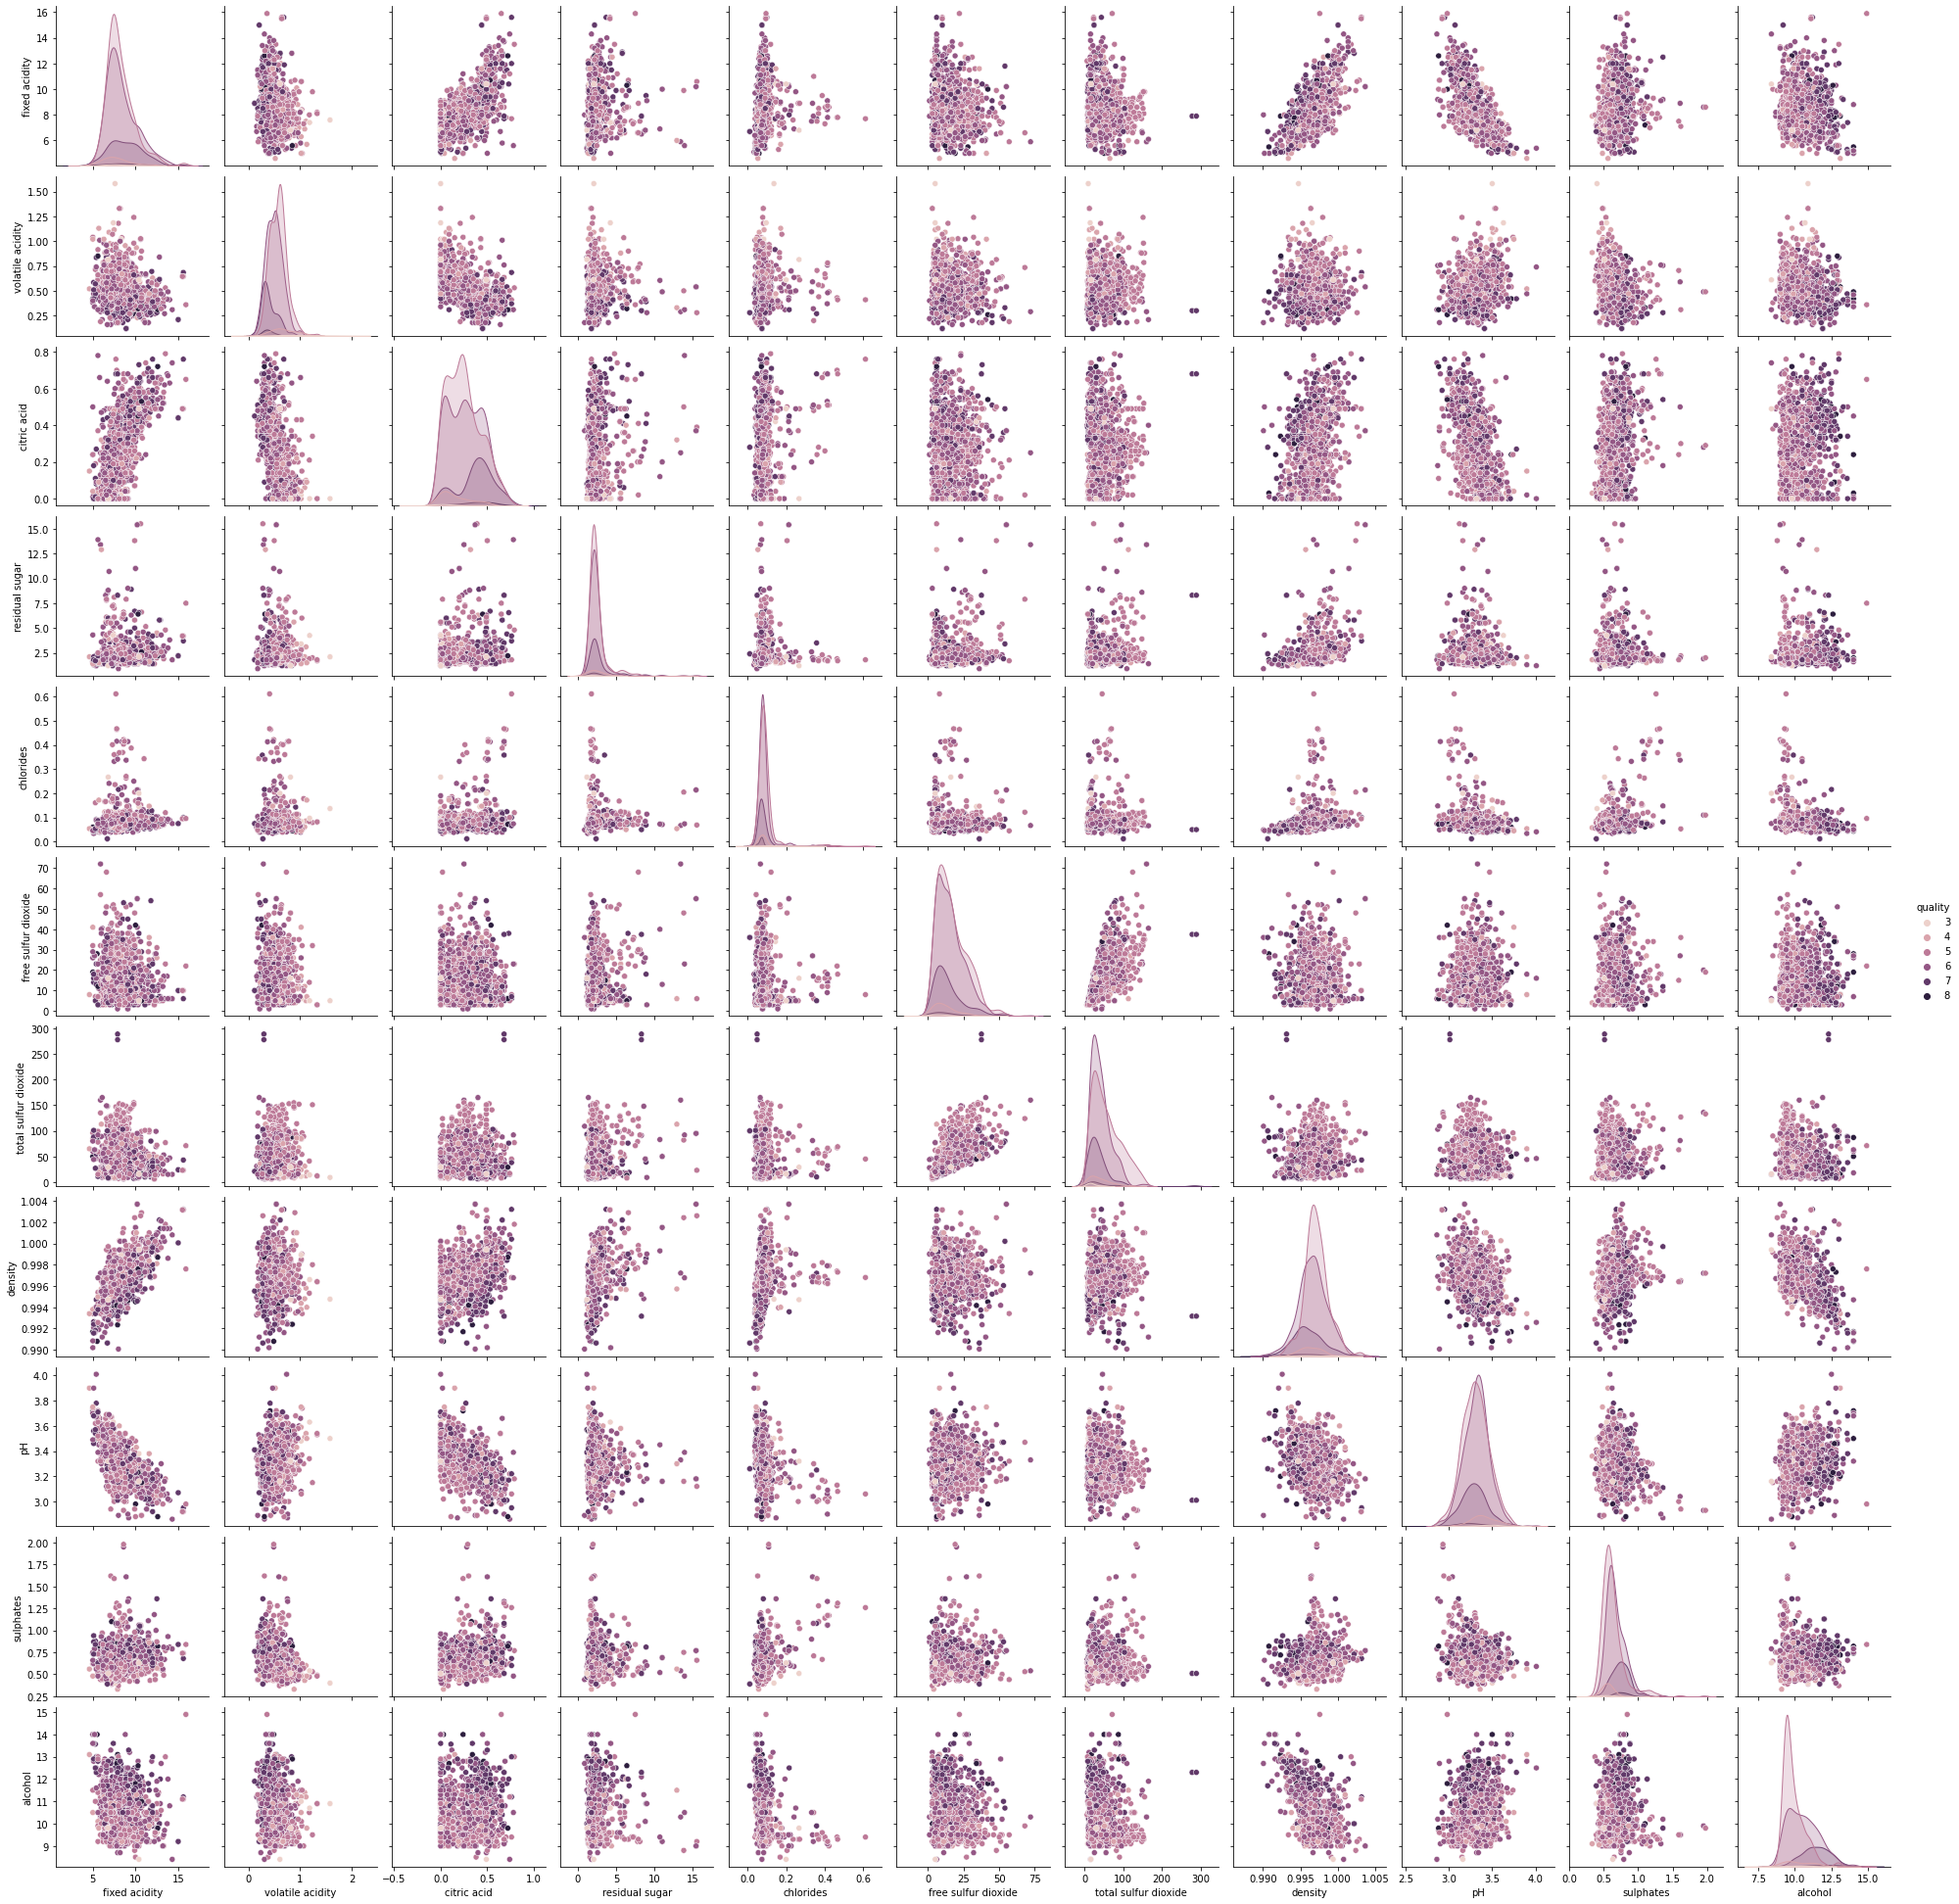

In [11]:
sns.pairplot(train, hue='quality');

In [12]:
utils.VIF(X_train)

('Low Multicollinearity!',
 array([ 3.07389133,  1.75308848,  3.05862454,  1.10142866,  1.46048231,
         1.97929531,  2.23184107, -0.00517207,  2.26784033,  1.34956851,
         1.32223964]))

Although it appears from the matrix that fixed acidity and density, as well as fixed acidity and pH, are somewhat linearly dependent, the VIF analysis shows that should not be a concern since all VIF scores are less than 5. 

[Back to Top](#Table-of-Contents)

## Modeling

Four predictive models are constructed from the training set and applied to the testing set: 

- [Ordinary Least Squares](#Ordinary-Least-Squares)
- [Ridge](#Ridge-Regression)
- [Lasso](#Lasso-Regression)
- [Elastic Net](#Elastic-Net-Regression)

To gauge the quality of my regression algorithm implementations, comparisons with the associated Scikit-Learn algorithm are detailed at the end of each section. Furthermore, to preserve the simplicity of this notebook, functions for linear regression are called from `src/linear_regression.py` with utilities used called from `src/utilities.py`. K-Fold cross-validation is also implemented (found at `src/cross_validation.py`) using basic libraries and used for model hyperparameter tuning.

### Ordinary Least Squares

#### Deriving the Ordinary Least Squares Estimator

In an Ordinary Least Squares (OLS) model, the response is modeled as a linear function of its features:

$$y_i = \beta_1x_{i,1} + \beta_2x_{i,2} + \ldots + \beta_nx_{i,n} + \epsilon_i \space \forall \space i \in \{1, \ldots, N\} \: \: \: \: \: \text{(n ~ number of features, N ~ number of samples, $\epsilon$ ~ error)}$$


To solve for the OLS estimator, the sum of squared error will be utilized as a loss function, where error (or residual) is defined as: 

$$ \hat{\mathbf{e}} = \mathbf{y} - \mathbf{X}\mathbf{\beta} $$

and the corresponding loss function is:

$$ L(\mathbf{\beta}) = \|\hat{\mathbf{e}}\|_2^2 =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2$$

Furthermore, this problem can now be formalized as a least squares optimization problem, which serves to derive estimates for the model parameters, $\mathbf{\beta}$, that minimize the sum of squared error between actual and predicted values of the outcome: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} $$

Aided by the problem's unconstrained nature, a closed-form solution for the OLS estimator can be derived by setting the gradient of the loss function (objective) equal to zero and solving the resultant equation, which produces:

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}(\mathbf{X}^T\mathbf{y}) $$

To show that this solution is the unique (global) minimizer to the OLS problem, it will suffice to show that the loss function (3) is convex. Second-order convexity conditions state that a function is convex if it is continuous, twice differentiable, and has an associated  Hessian matrix that is positive semi-definite. 

Due to its quadratic nature, the OLS loss function (3) is both continuous and twice differentiable. To establish the last second-order condition, the Hessian matrix of the OLS loss function (3) is found as: 

$$\mathbf{H} = 2\mathbf{X}^T\mathbf{X} $$

Furthermore, this Hessian matrix can be shown to be positive semi-definite as:

$$ \mathbf{\beta}^T (2\mathbf{X}^T\mathbf{X}) \beta = 2(\mathbf{X}\beta)^T \mathbf{X}\beta = 2 \|\mathbf{X}\mathbf{\beta}\|_2^2 \succeq 0 \: \: \: \forall \: \: \: \mathbf{\beta}$$

Thus, by the second-order conditions for convexity, the OLS loss function (3) is convex. 

Therefore, any local minimum of this function is also a global minimum, which implies that the OLS estimator found above (5) is the unique minimizer to the least squares (OLS) regression problem.

#### Inclusion of an Intercept Term

In this particular application of OLS, an intercept term, $\beta_0$, should be included in the model. This can be accomplished through augmentation of the design matrix with a constant column of ones producing the optimization problem:

\begin{align}
\begin{bmatrix}
    \hat{\beta}_0\\
    \hat{\beta}\\
\end{bmatrix}
&=
\arg\min_{\beta_0,\beta} \left\Vert\mathbf{y}-\begin{bmatrix} \mathbf{1_n} & \mathbf{X} \end{bmatrix}\begin{bmatrix}
    \beta_0\\
    \beta\\
\end{bmatrix}\right\Vert^2 _2
\end{align}

This optimization problem can then be solved for the OLS estimator (5).

#### Notes on Implementation 

Solving for the OLS estimator using the matrix inverse does not scale well, thus the NumPy function `solve`, which employs the LAPACK `_gesv` routine, is used to find the least squares solution. This function solves the equation $Ax = b$ in the case where A is square ($X^TX$) and full-rank (linearly independent columns), which is our case (full-rank being established through VIF analysis). However, in the case that A is not full-rank, then the function `lstsq` should be used, which utilizes the xGELSD routine and thus finds the singular value decomposition of A.

#### Comparisons with Scikit-Learn

A table is produced below detailing Scikit-Learn comparison runtimes, errors, and model parameters outputs.

In [4]:
utils.compare_ols(X_train, y_train, test_vals, list(train.columns[0:-1]))

,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.000633,112.026172,22.464534,0.006538,-0.952018,-0.086144,0.00959,-1.923678,0.00493,-0.003642,-17.443395,-0.659216,0.985946,0.269186
Scikit-Learn's Function,0.001203,112.026172,22.464534,0.006538,-0.952018,-0.086144,0.00959,-1.923678,0.00493,-0.003642,-17.443395,-0.659216,0.985946,0.269186


### Ridge Regression

#### Introduction

One way the predictive capability of an OLS model can be hampered is by overfitting the training set data. 

Since our modelling data is a sample taken from an overall population, and furthermore our training data a subsample of this sample, error (noise) can be introduced by idiosyncrasies unique to the sample. When training on such a sample, a model can become overfit when it uses patterns and relationships found within the sample, but not within the underlying population to make its predictions. 

This results in a predictive model with high variance (parameter predictions vary greatly from sample to sample) and low bias (error introduced by the modelling technique), which is sub-optimal in its capabilities. One possible way to improve performance in this case is to reduce variance by adding bias to the model.

For the case of OLS, this can be achieved through biasing parameter predictions towards zero (shrinkage). Ridge Regression (also known as Tikhonov regularization or $L_2$-regularization) achieves this shrinkage of the OLS predictions through the addition of an $L_2$ penalty to the loss function. 

#### Deriving the Ridge Estimator

The Ridge loss function is similar to the OLS loss function (3) but with the addition of an $L_2$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_2^2 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

The Ridge problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_2^2 $$

A closed-form solution can be analytically derived for the Ridge estimator similarly to the OLS case:

$$ {\hat {\beta }}=(\mathbf {X} ^{\mathsf {T}}\mathbf {X} +\lambda \mathbf {I} )^{-1}\mathbf {X} ^{\mathsf {T}}\mathbf {y} $$

This estimator can be shown to be unique similarly to the OLS case. First, the Hessian matrix is computed:

$$\mathbf{H} = 2\mathbf{X}^T\mathbf{X} + 2 \lambda \mathbf {I}$$

Next, this matrix is shown to be positive definite, implying strong convexity, as:

$$ \mathbf{\beta}^T (\mathbf{X}^T\mathbf{X} + \lambda \mathbf {I})\mathbf{\beta} = (\mathbf{X}\mathbf{\beta})\mathbf{X}\mathbf{\beta} + \lambda \mathbf{\beta}^T\mathbf{\beta} = \|\mathbf{X}\mathbf{\beta}\|_2^2 + \lambda \|\mathbf{\beta}\|_2^2 \succ 0 \: \: \: \forall \:\:\:  \mathbf{\beta} \neq \mathbf{0}$$

Establishing that the Ridge loss function is strongly convex implies that the Ridge estimator is the unique minimizer to the Ridge problem (10)

Note: $\lambda = 0$ produces the OLS estimate. Furthermore, features should be centered and scaled to unit variance to enable fair parameter shrinkage.

#### Inclusion of an Intercept Term

To obtain an intercept term for the Ridge case, data augmentation is utilized again resulting in the following optimization problem which can be solved for the corresponding estimator:

\begin{align}
\begin{bmatrix}
    \hat{\beta}_0\\
    \hat{\mathbf{\beta}}\\
\end{bmatrix}
&=
\arg\min_{\beta_0,\beta} \left\Vert \begin{bmatrix}\mathbf{Y} \\ 0 \end{bmatrix}-\begin{bmatrix} \mathbf{1_n} & \mathbf{X} \\
                                                            0 & \lambda \cdot \mathbf{I} \end{bmatrix}\begin{bmatrix}
    \beta_0\\
    \mathbf{\beta}\\
\end{bmatrix}\right\Vert^2 _2
\end{align}

#### Notes on Implementation

Similar to the OLS case

#### K-Fold Cross-Validation to Find $\lambda$

First, the features are scaled then a grid of tuning parameters is tested with five-fold cross-validation (CV). This grid consists of 2500 values between 0.001 and 10000 on a reverse log scale to enable a higher concentration of hyperparameters near zero to test via CV.

In [5]:
ridge_cv = cv.ridge(X_train, y_train, num_lambdas=500, k=5)
lambda_star_ridge = ridge_cv[-1]
print("Optimal tuning parameter value: ", lambda_star_ridge)

Optimal tuning parameter value:  0.006724427423484249


#### Comparisons with Scikit-Learn

In [6]:
utils.compare_ridge(X_train, y_train, test_vals, \
              features=list(train.columns[0:-1]), l=lambda_star_ridge)

,Runtime (s),Error,Y-Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
My Function,0.000501,111.674942,5.587598,0.009769,-0.172330,-0.016965,0.013506,-0.093092,0.051138,-0.120893,-0.032638,-0.103886,0.16232,0.287373
Scikit-Learn's Function,0.001365,112.026150,5.635653,0.011466,-0.171638,-0.016506,0.013846,-0.092584,0.051318,-0.120484,-0.033296,-0.102303,0.16258,0.287446


### The Lasso (Least Absolute Shrinkage and Selection Operator)

#### Introduction

Another form of shrinkage that can be applied to the OLS problem is the Lasso. In this case, an $L_1$ penalty is added to the loss function, which has the effect of bringing model parameters to zero for a large enough value of the associated tuning parameter. In other words, this penalty performs automated feature selection since possibly some of the model parameters will be brought to zero.  

However, unlike the previous models, no closed-form solution exists due to the fact that the loss function is no longer continuously differentiable (non-smooth absolute component). Thus, discrete optimization techniques are needed to solve for the parameter estimates. Numerous algorithms, such as the LARS (Least Angle Regression) algorithm and the Forward Stepwise regression algorithm have been developed to solve the Lasso, however the Pathwise Coordinate Descent algorithm is leveraged here. 

#### Finding the Lasso Estimator

The Lasso loss function is similar to the OLS loss function (3) but with the addition of an $L_1$ penalty:

$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_1 \: \: \: \text{ with tuning parameter $\lambda \geq 0$} $$

The Lasso problem is also formalized as a least squares optimization problem: 

$$ \hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}}  L(\mathbf{\beta}) = \arg\min_{\mathbf{\beta}} \|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} + \lambda\|\mathbf{\beta}\|_1 $$

In order to solve this problem, pathwise Coordinate Descent is implemented. The algorithm utilizes the notion of optimizing a single parameter at a time while holding all others fixed. 

Since the number of samples is much greater than the number of features in this case, covariance updates are used where cross-covariance terms are computed and stored for active variables. Warm starts, fitting a sequence of models ranging on a log scale from the maximum value of the tuning parameter down to a minimum value, are used to further speed up the convergence of the algorithm. 

An intercept term can be found similarly to the OLS case. 


#### K-Fold Cross-Validation

In [ ]:
lasso_cv = cv.lasso(X_train, y_train, num_lambdas=500, k=5)
lambda_star_lasso = lasso_cv[-1]
print("Optimal tuning parameter value: ", lambda_star_lasso)

#### Comparisons with Scikit-Learn

In [6]:
utils.compare_lasso(X_train, y_train, test_vals, \
              features=list(train.columns[0:-1]), l=lambda_star_lasso)

TypeError: descriptor 'flatten' for 'numpy.ndarray' objects doesn't apply to a 'numpy.float64' object

In [ ]:
train

In [ ]:
pd.DataFrame(index = ["OLS","Ridge","Lasso","Elastic Net"], 
              data = ({"Cross Validation Error": [ols_est,ridge[1],
                                                  lasso[1],elastic[2]]}))

In [ ]:
indice_alpha = np.where(elastic[5] == elastic[1])[0][0]
indice_lambda = np.where(elastic[4] == elastic[0])[0][0]
columns = np.append('Intercept', wine_data.columns.values[0:-1])
index = ["OLS","Ridge","Lasso standardized","Lasso unstandardized",\
         "Elastic Net standardized","Elastic Net unstandardized"]
data = np.append(np.append(np.append(
    np.append(np.append([ols(wine_data)], \ [ridge_regression(
        wine_data,ridge[0])],0), \ [lasso_regression_covar(
        wine_data,lasso[0])[0]],0),\ [unstandardize(
        lasso_regression_covar(wine_data,lasso[0])[0])],0),\
                 [elastic[-1][indice_alpha,:][indice_lambda,:]],0),\
                 [unstandardize(
    elastic[-1][indice_alpha,:][indice_lambda,:])],0)

pd.DataFrame(data = data, index = index, columns = columns)

In [ ]:
#Plot tuning parameters versus error and tuning parameters 
#versus coefficient value
fig = plt.figure(figsize=(20*1.5,9*1.5))
fig.tight_layout()

rid = fig.add_subplot(211)
rid.scatter(ridge[3], ridge[2])
rid.plot(ridge[3], ridge[2])
rid.set_xscale('log')
rid.set_xlabel('Log Lambda')
rid.set_ylabel("Cross Validation Error")
rid.set_title('Cross Validation Error for Ridge')

rid_coeff = fig.add_subplot(212)
rid_coeff.set_xlabel('Log Lambda')
rid_coeff.set_ylabel("Coefficients")
rid_coeff.set_title("Coefficient Path for Ridge")
for i in np.arange(1,12):
    rid_coeff.plot(ridge[3],ridge[4][:,i-1])
    rid_coeff.set_xscale('log')



In [ ]:
#Plot tuning parameters versus error and tuning parameters 
#versus coefficient value
fig2 = plt.figure(figsize=(20*1.5,9*1.5))
fig2.tight_layout()

las = fig2.add_subplot(211)
las.scatter(lasso[3], lasso[2])
las.plot(lasso[3], lasso[2])
las.set_xscale('log')
las.set_xlabel('Log Lambda')
las.set_ylabel("Cross Validation Error")
las.set_title('Cross Validation Error for Lasso')

las_coeff = fig2.add_subplot(212)
las_coeff.set_xlabel('Log Lambda')
las_coeff.set_ylabel("Coefficients")
las_coeff.set_title("Coefficient Path for Lasso")
for i in np.arange(1,12):
    las_coeff.plot(lasso[3],lasso[4][:,i])
    las_coeff.set_xscale('log')
    

In [ ]:
fig4,axs = plt.subplots(6,1,figsize = (25*1.5,30*1.5))

axs = axs.ravel()
for i in np.arange(1,7):
    X = elastic[4][int(99/(7-i)),:]
    Y = elastic[3][int(99/(7-i)),:]
    alpha = elastic[5][int(99/(7-i))]
    axs[i-1].plot(X,Y)
    axs[i-1].set_xscale('log')
    axs[i-1].set_xlabel('Log Lambda')
    axs[i-1].set_ylabel("Cross Validation Error")
    axs[i-1].set_title('Cross Validation Error for alpha = %f' %alpha)

In [ ]:
fig5 = plt.figure(figsize=(15,15))

elas_coeff = fig5.add_subplot(212)
elas_coeff.set_xlabel('Log Lambda')
elas_coeff.set_ylabel("Coefficients")
elas_coeff.set_title("Coefficient Path for Elastic Net")

indice = np.where(elastic[5] == elastic[1])[0][0]
for i in np.arange(1,12):
    elas_coeff.plot(elastic[4][indice,:],elastic[-1][indice,:][:,i])
    elas_coeff.set_xscale('log')